Import Required Libraries

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

Default Parameters

In [19]:
def default_params():
    return {
        'nu': 1,
        'betaD': 10,
        'betaR': 10,
        'h': 3,
        'm': 3,
        'sigma': 0.2,
        'P': 10,
        'Q': 10
    }

Get Connectivity Matrix

In [21]:
def get_connectivity_matrix(P, Q):
    k = P * Q
    M = np.zeros((k, k))
    w = 1 / 6
    
    for s in range(k):
        neighbors = find_neighbor_hex(s, P, Q)
        for r in range(6):
            M[s, neighbors[r]] = w
    return M

Find Neighbors in Hexagonal Grid

In [22]:
def find_neighbor_hex(ind, P, Q):
    p, q = ind2pq(ind, P)
    neighbors = [
        pq2ind((p % P) + 1, q, P),
        pq2ind((p - 2) % P + 1, q, P),
        pq2ind(p % P + 1, (q - 2) % Q + 1, P),
        pq2ind((p - 2) % P + 1, (q - 2) % Q + 1, P),
        pq2ind(p % P + 1, (q % Q) + 1, P),
        pq2ind((p - 2) % P + 1, (q % Q) + 1, P)
    ]
    return [n for n in neighbors if 0 <= n < P * Q]  # Ensure indices are within bounds

def pq2ind(p, q, P):
    return (p - 1) + (q - 1) * P

def ind2pq(ind, P):
    q = 1 + (ind // P)
    p = 1 + (ind % P)
    return p, q

Set Initial Conditions

In [23]:
def get_initial_conditions(params, k):
    U = np.random.rand(k) - 0.5
    epsilon = 1e-5
    D0 = epsilon * params['betaD'] * (1 + params['sigma'] * U)
    R0 = np.zeros(k)
    y0 = np.concatenate([D0, R0])
    return y0

Differential Equations

In [24]:
def li(y, t, params):
    nu = params['nu']
    betaD = params['betaD']
    betaR = params['betaR']
    h = params['h']
    m = params['m']
    M = params['connectivity']
    k = len(M)
    
    D = y[:k]
    R = y[k:2*k]
    Dneighbor = M.dot(D)
    
    dD = nu * (betaD / (1 + R**h) - D)
    dR = betaR * Dneighbor**m / (1 + Dneighbor**m) - R
    
    return np.concatenate([dD, dR])

Plot Two Cells

In [25]:
def plot_two_cells(t, y, k):
    fig, axes = plt.subplots(1, 2)
    for i in range(2):
        axes[i].plot(t, y[:, i], '-r', linewidth=2)
        axes[i].plot(t, y[:, k + i], '-b', linewidth=2)
        axes[i].set_title(f'cell #{i+1}')
        axes[i].set_xlabel('t [a.u]')
        axes[i].set_ylabel('concentration [a.u]')
        axes[i].legend(['D', 'R'])
    plt.show()

Plot Hexagon for Lattice

In [26]:
def plot_hexagon(p0, q0, c, ax):
    s32 = np.sqrt(3) / 4
    q = q0 * 3 / 4
    p = p0 * 2 * s32
    if q0 % 2 == 0:
        p += s32
    
    x = [q - 0.5, q - 0.25, q + 0.25, q + 0.5, q + 0.25, q - 0.25]
    y = [p, p + s32, p + s32, p, p - s32, p - s32]
    
    polygon = patches.Polygon(list(zip(x, y)), closed=True, color=c, linewidth=2)
    ax.add_patch(polygon)

Generate Movie Lattice

In [32]:
def movie_lattice(t, y, P, Q, k):
    fig, ax = plt.subplots()
    Cmax = np.max(y[-1, :k])
    
    def update(frame):
        ax.clear()
        Cmax = np.max(y[:, :k])
        for i in range(1, P + 1):
                for j in range(1, Q + 1):
                    ind = pq2ind(i, j, P)
                    if ind < k:  # Ensure the index is within bounds
                        mycolor = 0
                        if Cmax != 0:
                            mycolor = min(y[frame, ind] / Cmax, 1)
                        plot_hexagon(i, j, [1 - mycolor, 1 - mycolor, 1], ax)
        ax.set_aspect('equal')
        ax.axis('off')
    
    ani = FuncAnimation(fig, update, frames=range(0, len(t), 5), repeat=False)
    plt.show()
    return ani

Main Function

In [33]:
def multicell_LI(params=None):
    if params is None:
        params = default_params()
    
    P = params['P']
    Q = params['Q']
    k = P * Q
    
    params['connectivity'] = get_connectivity_matrix(P, Q)
    y0 = get_initial_conditions(params, k)
    
    t = np.linspace(0, 30, 300)
    y = odeint(li, y0, t, args=(params,))
    
    plot_two_cells(t, y, k)
    ani = movie_lattice(t, y, P, Q, k)
    
    return y, t, params, ani

Running the Simulation

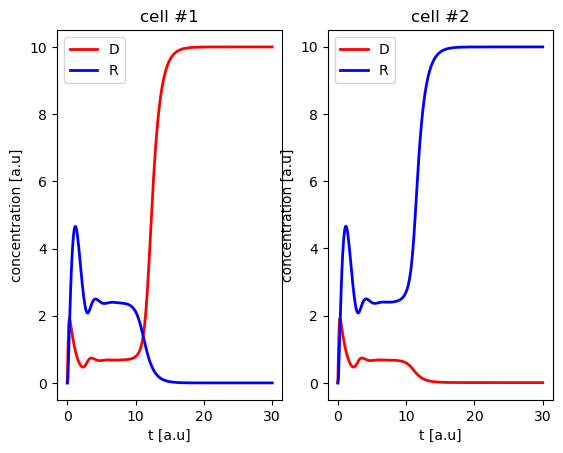

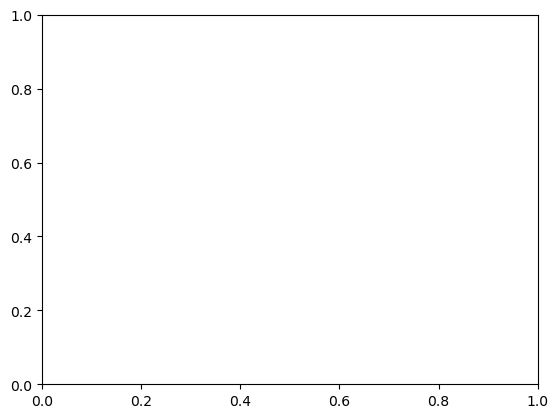

ValueError: too many values to unpack (expected 3)

In [34]:
y, t, params = multicell_LI()